# **Auto-Complete with N-gram Language Models**

---



## **Introduction**



The aim of this notebook is to develop a prototype of an auto-complete system step-by-step, starting from corpus preprocessing to the suggestions provided by the auto-complete system.



### **Basic setup**

In [ ]:
# nltk library packages
import nltk
nltk.download('all', quiet=True)

# pandas dataframe settings
import pandas as pd
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# progress_apply() bar using tqdm
from tqdm.notebook import tqdm
tqdm.pandas()


### **What is an auto-complete task in Natural Language Processing?**
An **auto-complete task** in natural language processing (NLP) involves predicting the next word or phrase that a user is likely to type, based on the context of the words that have been typed so far. This task is commonly used in search engines and text input fields to help users save time and effort by providing suggestions for completing a query or statement.

## **Collect and preprocess a large dataset of text**

First of all, we need to choose a corpus or a large collection of texts in order to build our language model based on N-grams. For this aim, I choose the Brown corpus, available from the `nltk` library.


### **Corpus selection: Brown Corpus**

The **Brown Corpus** was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on. 

Unlike the Reuters Corpus, in which categories overlap with each other, the Brown Corpus has a categorical structure, where the categories are disjoint.  

Of course, the choice of a particular corpus affect the language model that we want to build.

For ease of discussion, we consider only the first 2000 sentences of the Brown Corpus.


In [ ]:
from nltk.corpus import brown

# load the sentences of the corpus
corpus = brown.sents()

# fast preprocess
corpus = [" ".join(word for word in sent) for sent in corpus]

# build a Pandas dataframe starting from the corpus
df = pd.DataFrame(corpus[:2000], columns=["sentence"])
print(f"number of sentence: {df.shape[0]}")
df.head()

number of sentence: 2000


,sentence
0,The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
1,"The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted ."
2,The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .
3,"`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' ."
4,The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambiguous '' .


### **Build a function in order to preprocess a sentence**



The following preprocessing steps are required:
* **Lowercasing** (using `str.lower()` function)
* **Special characters removal**, such as (colon, commas, emojis, ...) (using `re.sub(...)` function)
* **Tokenization**  (using `nltk.word_tokenize(...)` function)
* adding needed **"Start-of-Sentence" token `<s>`**
* adding needed **"End-of-Sentence" token `<e>`**

**Why is it necessary to add SOS and EOS tokens?**

**SOS tokens** are added since we have no context for the words at the beginning of the sentence.

So, for a given N-gram model, we need to add $N-1$ SOS tokens. 

Indeed, **EOS tokens** are more relevant since the lack of them could cause some big issues. 

As Chen and Goodman (1998) point out, without an end-symbol, the sentence probabilities for all sentences of a given length would sum to one, and the probability of the whole language would be infinite. This identity must hold:

$$ \sum_{2 \; word} P(\dots) + \sum_{3 \; word} P(\dots) + \dots = 1$$

In addition, since we have that:

$$ P(y \mid x) = \frac{C(x \; y)}{\sum_w C(x \; w)} = \frac{C(x \; y)}{C(x)} $$

adding EOS tokens allow to keep holding this identity.

In this notebook, for this stage, the order $n$ of the n-grams considered is fixed at 3.

In [ ]:
import re

# order n of considered n-grams
N_ORDER = 3

def preprocess_sentence(sent, n=N_ORDER, sos_token="<s>", eos_token="<e>"):
  """
  Sentence preprocessing pipeline (lowercasing, special characters removal, tokenization, SOS/EOS)

  input:
    - sent: text string corresponding to a sentence
    - n: order of the n-grams considered
    - sos_token: start-of-sentence token (default is "<s>")
    - eos_token: end-of-sentence token (default is "<e>")
  output:
    - sent: preprocessed sentence

  """

  # sentence lowercasing
  sent = sent.lower()

  # removing special characters within the sentence
  sent = re.sub(r"[^a-zA-Z0-9.?! ]+", " ", sent)

  # sentence tokenization
  sent = nltk.word_tokenize(sent)

  # adding S0S and EOS symbols to the sentence
  sent = [sos_token] * (n-1) + sent + [eos_token]

  # return the preprocessed sentence
  return sent

# apply preprocess_sentence to each sentence in the dataset
df["sentence_preprocessed"] = df["sentence"].progress_apply(lambda x: preprocess_sentence(x, N_ORDER))
df.head()

  0%|          | 0/2000 [00:00<?, ?it/s]

,sentence,sentence_preprocessed
0,The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .,"[<s>, <s>, the, fulton, county, grand, jury, said, friday, an, investigation, of, atlanta, s, recent, primary, election, produced, no, evidence, that, any, irregularities, took, place, ., <e>]"
1,"The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .","[<s>, <s>, the, jury, further, said, in, term, end, presentments, that, the, city, executive, committee, which, had, over, all, charge, of, the, election, deserves, the, praise, and, thanks, of, the, city, of, atlanta, for, the, manner, in, which, the, election, was, conducted, ., <e>]"
2,The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .,"[<s>, <s>, the, september, october, term, jury, had, been, charged, by, fulton, superior, court, judge, durwood, pye, to, investigate, reports, of, possible, irregularities, in, the, hard, fought, primary, which, was, won, by, mayor, nominate, ivan, allen, jr., ., <e>]"
3,"`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .","[<s>, <s>, only, a, relative, handful, of, such, reports, was, received, the, jury, said, considering, the, widespread, interest, in, the, election, the, number, of, voters, and, the, size, of, this, city, ., <e>]"
4,The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambiguous '' .,"[<s>, <s>, the, jury, said, it, did, find, that, many, of, georgia, s, registration, and, election, laws, are, outmoded, or, inadequate, and, often, ambiguous, ., <e>]"


### **Split the sentences into train and test sets**

In this case, our dataset is splitted in such a way that the training set is formed by the **80%** of the initial dataset and the test set contains the remaining **20%**. 

In order to get the training and the test sets, we apply the `sklearn.model_selection.train_test_split(...)` function, passing our preprocessed sentences and the size of the test set.

In [ ]:
from sklearn.model_selection import train_test_split

# split and transform the initial dataset into training and test sets/dataframes (0.8-0.2)
train_df, test_df = train_test_split(df["sentence_preprocessed"], test_size=0.2)
train_df, test_df = pd.DataFrame(train_df), pd.DataFrame(test_df)

# print the number of sentences in the training and test sets, respectively
print(f"number of sentences in the training set: {train_df.shape[0]}")
print(f"number of sentences in the test set: {test_df.shape[0]}")

number of sentences in the training set: 1600
number of sentences in the test set: 400


### **Replace words with a low frequency by an unknown marker `<UNK>`**

In this section, we consider a possible approach in order to handle out-of-vocabulary words. 

The percentage of OOV words that appear in the test set is called the **OOV rate**.

An **open vocabulary** system is one where we model these potential unknown words in the test set by adding a pseudo-word called `<UNK>`. 

We can train the probabilities
of the unknown word model `<UNK>` as follows:
1. Choose a vocabulary (word list) which is fixed in advance.
2. Convert in the training set any word that is not in this set (any OOV word) to the unknown word token `<UNK>` in a text normalization step.
3. Estimate the probabilities for `<UNK>` from its counts just like any other regular word in the training set.


Mainly, there are two possible criteria for handling OOV words:
* Considering a maximum limited size $M$ for our vocabulary (e.g. considering only the most $M$ frequent words);
* Using the Minimum Frequency Criterion, so that our vocabulary contains words, whose frequency is greater or equal a given threshold).

In this notebook, the Min-Frequency Criterion is applied.


### **Minimum-Frequency Criterion**

The following code section helps us to visualize the most 50 frequent word tokebs in our corpus using a bar-plot in order to have an idea of them.

Punctuation symbols and stopwords are excluded for this scope.


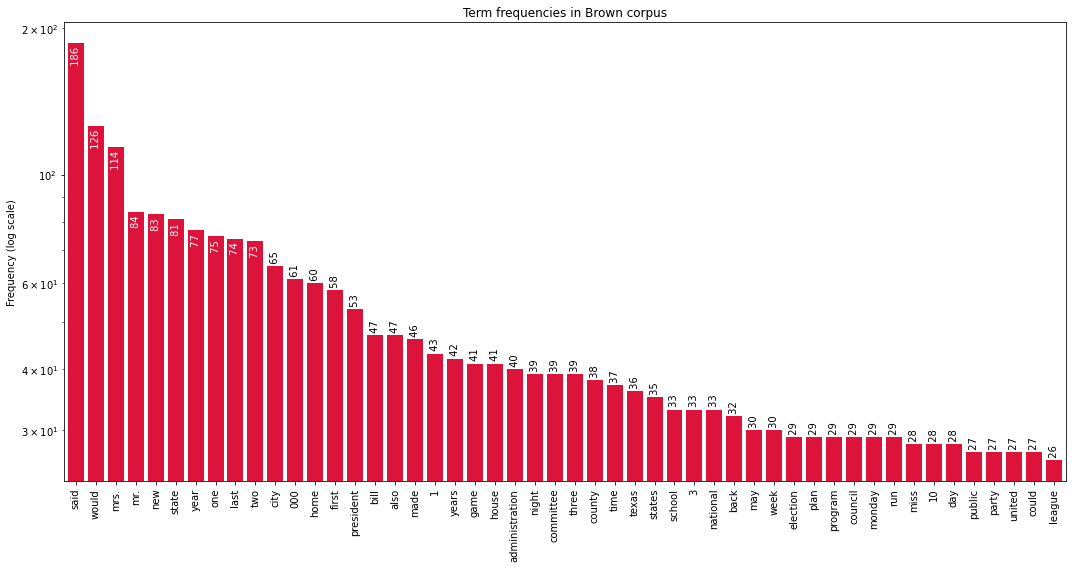

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
plt.rcParams["figure.figsize"] = (15,8)

# build the set of excluded symbols/word tokens for visualization aim
excluded_symbols = list(set(stopwords.words('english')) | set(string.punctuation) | set(["<e>", "<s>"]))

# build a vocabulary starting from the preprocessed sentences in the training set
vocab = Counter([word for sent in train_df['sentence_preprocessed'] for word in sent if word not in excluded_symbols])

# extract the first 50 common words from the words distribution of the training set, exlcuding sos/eos symbols, stopwords, punctuation
x = [word for word, count in vocab.most_common(50)]
y = [count for word, count in vocab.most_common(50)]

# plot the Term frequencies
plt.bar(x, y, color='crimson')
plt.title("Term frequencies in Brown corpus")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(vocab.most_common(50)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

The Minimum Frequency threshold has to be appropriately fixed in order to get a trade-off between cases in which the probability of the unknown token `<UNK>` is not high enough to be in the most likely words of our language model and considering several contexts for each word in the vocabulary.

Since the appropriate Minimum Frequency threshold has to be chosen empirically, it could be helpful visualizing the Zipf's Law for the Brown corpus. 

**REMINDER: What is the Zipf's Law?**

**Zipf's Law** states that the frequency of a token in a text is directly proportional to its rank or position in the sorted list. This law describes how tokens are distributed in languages: some tokens occur very frequently, some occur with intermediate frequency, and some tokens rarely occur.

The following code section allows us to plot the Zipf's Law.

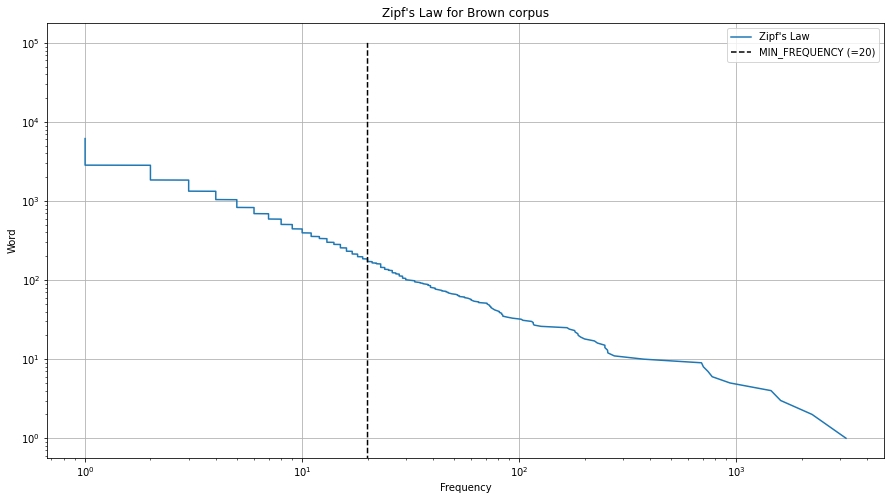

In [ ]:
import numpy as np
import math
from nltk import FreqDist
plt.rcParams["figure.figsize"] = (15,8)

# choose a minimum frequency
MIN_FREQ = 20

# create a FreqDist object 
fd = FreqDist(word for sent in train_df['sentence_preprocessed'] for word in sent)

# Generate a (rank, frequency) point for each counted token and append to the respective lists.
# Note that the iteration over fd is automatically sorted.
ranks, freqs = [], []
for rank, word in enumerate(fd):
  ranks.append(rank+1)
  freqs.append(fd[word])

# plot the Zipf's Law
plt.loglog(freqs, ranks, label='Zipf\'s Law')
plt.grid()
plt.title("Zipf's Law for Brown corpus")
plt.ylabel("Word")
plt.xlabel("Frequency")

plt.plot([MIN_FREQ for idx in range(0, 100_000, 1)], np.linspace(0, 100_000, 100_000), linestyle='dashed', color='black', label=f"MIN_FREQUENCY (={MIN_FREQ})")
plt.legend()
plt.show()

As we can see, on the left part of this plot, there is a certain number of words, which have a very low frequency in the whole corpus. So, we could estimate that a good threshold could be fixed at 20

So, we create our vocabulary considering words that appear at least 20 times.

Notice that increasing the min frequency, the number of added UNK tokens increases too. This behiavior will affect the suggestions provided in the last section of the notebook.

The choice of the treshold as minimum word frequency may affect the performance of the language model, in terms of perplexity. 

In [ ]:
def get_vocabulary_using_min_frequency_criterion(corpus, min_frequency=MIN_FREQ):

  # build a vocabulary starting from the preprocessed sentences in the training set
  vocab = Counter(word for sent in corpus for word in sent)
  # extract the words from the vocabulary using min-frequency criterion
  vocabulary_unk = [word for word, count in vocab.items() if count >= min_frequency or word in ['<s>', '<e>']]
  return vocabulary_unk, [word for word, count in vocab.items()] 

vocabulary_unk, vocabulary = get_vocabulary_using_min_frequency_criterion(train_df['sentence_preprocessed'], MIN_FREQ)
print(f"Vocabulary size (V) with UNKs: {len(vocabulary_unk)}")
print(f"Vocabulary size (V) without UNKs: {len(vocabulary)}")


Vocabulary size (V) with UNKs: 185
Vocabulary size (V) without UNKs: 6163


Thus, we build a `handling_oov(...)` function in order to handle out-of-vocabulary words from the vocabulary just built.


In [ ]:
# string for the unknown token
UNK_TOKEN = "<UNK>" 

# replacing unfrequent words with <UNK>
def handling_oov(sent, vocabulary, unk_token="<UNK>", sos_token="<s>", eos_token="<e>"):
  text = []
  for word in sent:
    if word not in vocabulary and word not in [sos_token, eos_token]:
      text.append(unk_token)
    else:
      text.append(word)
  return text

# apply handling_oov to the training and test sets
train_df["sentence_without_oov"] = train_df["sentence_preprocessed"].progress_apply(lambda x: handling_oov(x, vocabulary_unk))
test_df["sentence_without_oov"] = test_df["sentence_preprocessed"].progress_apply(lambda x: handling_oov(x, vocabulary_unk))

# add the unknown token to the vocabulary
vocabulary_unk.append(UNK_TOKEN)

# show first 5 rows of the training set
train_df.head()

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

,sentence_preprocessed,sentence_without_oov
457,"[<s>, <s>, mr., martinelli, explained, that, there, should, be, more, than, enough, signatures, to, assure, the, scheduling, of, a, vote, on, the, home, rule, charter, and, possible, election, of, a, nine, member, charter, commission, within, 70, days, ., <e>]","[<s>, <s>, mr., <UNK>, <UNK>, that, there, should, be, more, than, <UNK>, <UNK>, to, <UNK>, the, <UNK>, of, a, <UNK>, on, the, home, <UNK>, <UNK>, and, <UNK>, election, of, a, <UNK>, <UNK>, <UNK>, <UNK>, <UNK>, <UNK>, <UNK>, ., <e>]"
343,"[<s>, <s>, this, is, another, of, the, modifications, of, policy, on, laos, that, the, kennedy, administration, has, felt, compelled, to, make, ., <e>]","[<s>, <s>, this, is, <UNK>, of, the, <UNK>, of, <UNK>, on, <UNK>, that, the, <UNK>, administration, has, <UNK>, <UNK>, to, <UNK>, ., <e>]"
468,"[<s>, <s>, our, most, immediate, goal, is, to, increase, public, awareness, of, the, movement, he, indicated, and, to, tell, them, what, this, will, mean, for, the, town, ., <e>]","[<s>, <s>, <UNK>, most, <UNK>, <UNK>, is, to, <UNK>, public, <UNK>, of, the, <UNK>, he, <UNK>, and, to, <UNK>, them, what, this, will, <UNK>, for, the, <UNK>, ., <e>]"
276,"[<s>, <s>, the, scholarship, plan, would, provide, federal, contributions, to, each, medical, and, dental, school, equal, to, 1, 500, a, year, for, one, fourth, of, the, first, year, students, ., <e>]","[<s>, <s>, the, <UNK>, plan, would, <UNK>, <UNK>, <UNK>, to, each, <UNK>, and, <UNK>, school, <UNK>, to, 1, <UNK>, a, year, for, one, <UNK>, of, the, first, year, <UNK>, ., <e>]"
359,"[<s>, <s>, this, group, pleads, with, the, administration, to, give, no, further, support, for, the, invasion, of, cuba, by, exile, groups, ., <e>]","[<s>, <s>, this, <UNK>, <UNK>, with, the, administration, to, <UNK>, no, <UNK>, <UNK>, for, the, <UNK>, of, <UNK>, by, <UNK>, <UNK>, ., <e>]"


Here there is some statistics in order to have an idea of how many unknown tokens are added, the average of unknown tokens per sentence and so on.

In [ ]:
# extract the number of unknown tokens added
unk_tokens = Counter(word for sent in train_df['sentence_without_oov'] for word in sent)[UNK_TOKEN]

# get the number of sentences in the training set
sentences = train_df.shape[0]

# get the number of words per sentence
words_per_sent = sum([len(sent) for sent in train_df['sentence_without_oov']])/sentences

# print results
print(f"number of <UNK> tokens added : {unk_tokens}")
print(f"average of <UNK> tokens per sentence: {unk_tokens/sentences:.2f} tokens")
print(f"average of words per sentence: {words_per_sent:.2f} words")

number of <UNK> tokens added : 15303
average of <UNK> tokens per sentence: 9.56 tokens
average of words per sentence: 23.59 words




---

## **Develop N-gram based language models**

### **What are language models and how they are used in NLP tasks such as auto-complete?**

A **language model** is a machine learning model that is trained to predict the likelihood of a sequence of words occurring in a given language. In natural language processing (NLP), language models are used to analyze and understand language data, such as text or speech.

Language models are trained on large datasets of text and use statistical techniques to learn the patterns and structures of a language. They can then be used to generate text that is coherent and sounds natural to a human reader.


There are several types of language models that can be used in NLP tasks, including:

* **Statistical language models**: These models use statistical techniques to estimate the probability of a sequence of words occurring in a given language. They are often trained on large corpora of text data and use techniques such as n-grams or Markov chains to predict the next word in a sequence.

* **Neural language models**: These models use deep learning techniques to analyze and predict the likelihood of a sequence of words occurring in a given language. They are trained on large amounts of text data and use artificial neural networks to learn complex patterns and relationships within the data.

* **Transformer language models**: These models use transformer architectures to analyze and understand language data. They are trained on large amounts of text data and are able to capture long-range dependencies and context within the data, making them particularly effective at tasks such as language translation and summarization.

In this case, we will use a **statistical language model based on N-grams**.




### **What is an N-gram?**

An **N-gram** is a contiguous sequence of n items from a given sample of text or speech. In the context of language modeling, an n-gram is a sequence of n words that appear in a text.

For example, in the sentence "The quick brown fox jumps over the lazy dog," the following are some examples of unigrams (n=1), bigrams (n=2), and trigrams (n=3):

* **Unigrams** (n=1): The, quick, brown, fox, jumps, over, the, lazy, dog
* **Bigrams** (n=2): The quick, quick brown, brown fox, fox jumps, jumps over, over the, the lazy, lazy dog
* **Trigrams** (n=3): The quick brown, quick brown fox, brown fox jumps, fox jumps over, jumps over the, over the lazy, the lazy dog.

N-grams are commonly used in natural language processing tasks, such as language modeling, text classification, and information retrieval.

**The idea behind N-grams**

We'll represent a sequence of $N$ words either as $w_1 \dots w_n$ or $w_1^n$. 
It is possible to compute the probability of the entire sequence $P(w_1, w_2, \dots, w_n)$ decomposing this probability using the **chain rule of probability**, from we get:

$$ P(w_1 \dots w_n) = P(w_1)P(w_2 \mid w_1) P(w_3\mid w_1^2) \dots P(w_n \mid w_1^{n-1}) $$

$$ = \prod_{k=1}^{n} P(w_k \mid w_1^{k-1}) $$
The **chain rule** shows the link between computing the joint probability of a sequence
and computing the conditional probability of a word given previous words.

Since we don’t know any way to compute the
exact probability of a word given a long sequence of preceding words, $ P(w_n \mid w_1^{n-1})$, we can’t just estimate by counting the number of times every word occurs following every long string, because language is creative and any particular context might have never occurred before!




### **Markov Assumption for the N-gram approximation of the sequence probability**
The intuition of the N-gram model is that instead of computing the probability of a word given its entire history, we will approximate the history by just the last few words.

This assumption that the probability of a word depends only on the previous word is called a **Markov assumption**. 

Markov models are the class of probabilistic models that assume that we can predict the probability of some future unit without looking too far into the past. 

The general equation for this N-gram approximation to the conditional probability of the next word in a sequence is:

$$ P(w_n\mid w_1^{n-1})  \approx P(w_n \mid w_{n-N+1}^{n-1}) $$

**Maximum Likelihood Estimation**

The simplest and most intuitive way to estimate probabilities is called Maximum Likelihood Estimation.

For the general case of MLE N-gram parameter estimation:

$$  P(w_n \mid w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}, w_n)}{C(w_{n-N+1}^{n-1})}$$

This equation estimates the N-gram probability by dividing the observed frequency of a particular sequence by the observed frequency of a prefix. This ratio is called a **relative frequency**.

### **Extract N-grams from the training set and calculate their frequency**

In an n-gram language model, a **count matrix** is a matrix that represents the number of times each n-gram appears in a dataset of text. The rows of the matrix correspond to the unique n-grams in the dataset, and the columns represent the words that follow each n-gram. The entries in the matrix are the number of times each combination of n-gram and following word appears in the text.

Once you have calculated the probabilities of the n-grams, you can use this information to train your language model and make predictions about the probability of a given word given the previous words in a sentence.

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from tqdm import tqdm
from pprint import pprint

def extract_ngrams(corpus, n=N_ORDER, sos_token="<s>"):
    """
    Extracts all possible n-grams of order n from the input corpus and compute the count matrix.
    
    Args:
        corpus: Pre-processed and tokenized sentences of a given corpus. 
        n: the order of the n-gram 
    
    Returns:
        prefixes: list of prefixes
        vocabulary: list of unique words
        count_matrix: matrix which contains all possible ngrams counts.
    """
    prefixes = set()
    vocabulary = set()
    count_matrix_dict = {}

    for sentence in tqdm(corpus, desc=f"Computing {n}-grams..."):
      for i in range(0, len(sentence)- (n-1)):

        # extract n-gram from the sentence
        ngram = tuple(sentence[i: i + n])

        # extract the (n-1)-gram, also called prefix, from the n-gram
        prefix = ngram[0:-1] 

        # add prefix to the set of prefixes
        prefixes.add(prefix)

        # extract the last word of the n-gram
        last_word = ngram[-1]

        # add last_word to the vocabulary
        vocabulary.add(last_word)

        if (prefix,last_word) not in count_matrix_dict:
              count_matrix_dict[prefix,last_word] = 0
        
        # increase the count of the ngram
        count_matrix_dict[prefix,last_word] += 1
    
    # add the sos_token to the vocabulary
    vocabulary.add(sos_token)

    # convert sets to lists
    prefixes, vocabulary = list(prefixes), list(vocabulary)

    # convert the count_matrix to np.array to fill in the blanks
    count_matrix = np.zeros((len(prefixes), len(vocabulary)))
    for ngram_key, ngram_count in tqdm(count_matrix_dict.items(), desc="Building count_matrix..."):  # items() returns key-value pairs as a tuple
        count_matrix[prefixes.index(ngram_key[0]), vocabulary.index(ngram_key[1])] = ngram_count
            
    # np.array to pandas dataframe conversion
    count_matrix = pd.DataFrame(count_matrix, index=prefixes, columns=vocabulary)
    return prefixes, vocabulary, count_matrix


# computing the count matrices with/without UNKs
print("Computing the count matrix with UNKs")
prefixes_unk, vocabulary_unk, count_matrix_unk = extract_ngrams(train_df['sentence_without_oov'], N_ORDER)

print("\nComputing the count matrix without UNKs")
prefixes, vocabulary, count_matrix = extract_ngrams(train_df['sentence_preprocessed'], N_ORDER)

print("Showing the first entries of count_matrix_unk")
count_matrix_unk.head()

Computing the count matrix with UNKs


Building count_matrix...: 100%|██████████| 8953/8953 [00:00<00:00, 11650.18it/s]



Computing the count matrix without UNKs


Building count_matrix...: 100%|██████████| 31142/31142 [00:59<00:00, 524.96it/s]


Showing the first entries of count_matrix_unk


,there,<e>,up,government,because,them,if,man,city,party,for,before,new,this,him,department,could,should,democratic,we,not,run,so,jr.,an,states,on,house,public,a,against,team,administration,in,was,1,million,get,week,into,committee,general,game,night,three,<s>,when,to,she,state,10,through,texas,must,all,over,by,national,election,who,what,court,off,its,would,schools,can,5,per,any,those,have,under,had,then,other,her,county,out,ll,members,his,bill,council,were,here,four,last,be,as,take,of,league,united,are,only,each,may,some,did,year,work,from,jury,but,more,a.,ball,plan,where,the,.,program,made,school,<UNK>,now,two,session,after,you,next,or,mayor,local,board,president,at,miss,years,than,one,i,and,monday,tax,they,law,time,2,between,with,washington,tuesday,j.,such,down,3,right,expected,told,home,several,mrs.,that,back,these,he,since,their,first,t,play,mr.,s,said,which,000,day,just,it,most,about,john,during,yesterday,is,club,also,been,sunday,will,director,has,season,no
"(members, of)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(a, new)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(<UNK>, but)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,15.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
"(before, a)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### **Estimate the conditional probability of a next word with k-smoothing**

The **probability matrix** is derived from the count matrix, which is a matrix that represents the number of times each n-gram appears in a dataset of text. To create the probability matrix, the entries in the count matrix are divided by the total number of times each n-gram appears in the text.

So, we divide each ngram count by the corresponding row sum of the prefix and then we apply the **k-smoothing.**
 
**K-smoothing**

The idea behind k-smoothing is to avoid assigning a probability of zero to words that do not appear in the training data, as this can lead to poor performance in tasks such as autocomplete. Instead, k-smoothing adds a small, non-zero probability to all words, even those that do not appear in the training data. This helps to smooth the probability distribution of words, making it less prone to errors caused by the presence of rare or unseen words.

With the proper proportions, also the choice of the parameter $k$ affect the probabilities and then the perplexities performed by a given language model.



$$  P_{k}(w_n \mid w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}, w_n) + k}{C(w_{n-N+1}^{n-1}) + k \; \times V}$$

where:
* $k$ is called **smoothing factor** (real value between 0 and 1, empirically chosen);
* $V$ is the size of the vocabulary.


In [ ]:
from pprint import pprint
import math 

# smoothing factor 
K_SMOOTHING_FACTOR = 0.01

def compute_prob_matrix_with_k_smoothing(count_matrix, vocabulary_size, k_smoothing_factor=K_SMOOTHING_FACTOR):
  """
  Computing the log probability matrix, applying k-smoothing for ngrams stored in a dictionary.

  Input:
    - count_matrix: matrix which contains all possible ngrams counts.
    - vocabulary size: size of the vocabulary
    - k_smoothing_factor: factor that has to be used when applying k-smoothing
  Output:
    - prob_matrix: k-smoothed probability matrix 

  """
  # create the probability matrix from the count matrix
  row_sums = count_matrix.sum(axis=1)

  # apply k-smoothing for numerators
  count_matrix = count_matrix + k_smoothing_factor
    
  # apply k-smoothing for denominators
  row_sums = row_sums + k_smoothing_factor * vocabulary_size

  # divide each row by its sum smoothed
  prob_matrix = count_matrix.div(row_sums,axis=0)

  # log probability matrix
  prob_matrix = np.log(prob_matrix)
  return prob_matrix

# compute the probability matrices with k-smoothing and with/without UNKs
prob_matrix_unk = compute_prob_matrix_with_k_smoothing(count_matrix_unk, len(vocabulary_unk))
prob_matrix = compute_prob_matrix_with_k_smoothing(count_matrix, len(vocabulary))

print("Displaying the first entries of prob_matrix_unk")
prob_matrix_unk.head()


Displaying the first entries of prob_matrix_unk


,there,<e>,up,government,because,them,if,man,city,party,for,before,new,this,him,department,could,should,democratic,we,not,run,so,jr.,an,states,on,house,public,a,against,team,administration,in,was,1,million,get,week,into,committee,general,game,night,three,<s>,when,to,she,state,10,through,texas,must,all,over,by,national,election,who,what,court,off,its,would,schools,can,5,per,any,those,have,under,had,then,other,her,county,out,ll,members,his,bill,council,were,here,four,last,be,as,take,of,league,united,are,only,each,may,some,did,year,work,from,jury,but,more,a.,ball,plan,where,the,.,program,made,school,<UNK>,now,two,session,after,you,next,or,mayor,local,board,president,at,miss,years,than,one,i,and,monday,tax,they,law,time,2,between,with,washington,tuesday,j.,such,down,3,right,expected,told,home,several,mrs.,that,back,these,he,since,their,first,t,play,mr.,s,said,which,000,day,just,it,most,about,john,during,yesterday,is,club,also,been,sunday,will,director,has,season,no
"(members, of)",-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-2.463221,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-2.463221,-7.078342,-7.078342,-7.078342,-7.078342,-2.463221,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-0.861735,-7.078342,-7.078342,-7.078342,-7.078342,-1.775037,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342,-7.078342
"(a, new)",-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.990257,-6.9902

**Why should we consider the log probability instead of the raw probability?**

There are several reasons why it is often useful to consider the log probability instead of the raw probability when working with language models:

* **Numerical stability**: When working with very large datasets, the probabilities of individual events can become very small, which can lead to numerical instability and rounding errors. Taking the logarithm of the probability scales the values and can improve numerical stability.

* **Ease of calculation**: Calculating the log probability of an event is often easier than calculating the raw probability. For example, in an n-gram language model, the log probability of a sequence of words can be calculated by summing the log probabilities of the individual n-grams, rather than multiplying the probabilities together.


Using log probabilities can simplify calculations and avoiding probability underflows, improving the interpretability and stability of our language model.

$$ P(w_1^n)  \approx \prod_{i=1}^n P(w_i \mid w_{i-1})$$

$$ \Rightarrow \log (P(w_1^n)) \approx \sum_{i=1}^n \log (P(w_i \mid w_{i-1})) $$

$$ \Rightarrow P(w_1^n) = e^{\log (P(w_1^n))} $$

### **Getting sentence probability**

Since of course this sequence will cross many sentence boundaries, we need to include the begin- and end-sentence markers `<s>` and `<e>` in the probability computation.

In [ ]:
import math
def get_sentence_probability(sentence, prob_matrix, vocabulary_size, n=N_ORDER, k_smoothing_factor=K_SMOOTHING_FACTOR):
  """
  Computes the sentence probability of a given sentence.

  Input:
    - sentence: preprocessed sentence
    - prob_matrix: k-smoothed probability matrix
    - vocabulary size: size of the vocabulary
    - n: order n of the ngrams considered
    - k_smoothing_factor: factor that has to be used when applying k-smoothing
  Output:
    - prob_sent: sentence probability for the input sentence.
  """
  prob_sent = 0
  prob_ngrams = []
  # for each possible ngram within the sentence
  for i in range(0, len(sentence) - (n-1)):

    # extract the ngram
    ngram = tuple(sentence[i:i+n])
    prefix = ngram[0:-1]
    word = ngram[-1]

    try:
      # get the ngram probability
      ngram_prob = prob_matrix[word][prefix]
    except KeyError:
      # avoiding zero counts when using out-of-vocabulary words
      ngram_prob = math.log(k_smoothing_factor/(k_smoothing_factor * vocabulary_size))

    # add ngram log probability in order to get the sentence probability
    prob_sent += ngram_prob

    prob_ngrams.append({ngram: ngram_prob})
  
  # return the sentence probability
  return prob_sent

  # return the sentence probability
  return prob_sent

Here is an example of computing sentence probability.

In [ ]:
# example of input sentence
input_sentence = "Another good day in the last year." 
print(f"Input sentence: {input_sentence}")

# preprocess sentence
preprocessed_sentence = preprocess_sentence(input_sentence)
print(f"Preprocessed sentence: {preprocessed_sentence}")

# replacing oov words by unknown markers
sentence_no_oov = handling_oov(preprocessed_sentence, vocabulary_unk)
print(f"Sentence after preprocessing + handling_oov(): {sentence_no_oov} -> prob: {math.exp(get_sentence_probability(sentence_no_oov, prob_matrix_unk, len(vocabulary_unk)))}")
print(f"Sentence after preprocessing: {preprocessed_sentence} -> prob: {math.exp(get_sentence_probability(preprocessed_sentence, prob_matrix, len(vocabulary)))}")


Input sentence: Another good day in the last year.
Preprocessed sentence: ['<s>', '<s>', 'another', 'good', 'day', 'in', 'the', 'last', 'year', '.', '<e>']
Sentence after preprocessing + handling_oov(): ['<s>', '<s>', '<UNK>', '<UNK>', 'day', 'in', 'the', 'last', 'year', '.', '<e>'] -> prob: 4.9618788666094046e-14
Sentence after preprocessing: ['<s>', '<s>', 'another', 'good', 'day', 'in', 'the', 'last', 'year', '.', '<e>'] -> prob: 1.5771830559316427e-24




---



## **Evaluate the N-gram models by computing the perplexity score**

### **How the performance of a language model is evaluated**
The best way to evaluate the performance of a language model is to embed it in an application and measure the total performance of the application. Such end-to-end evaluation is called **extrinsic evaluation**.

An **extrinsic evaluation** is the only way to know if a particular improvement in a component is really going to help the task at hand.
Unfortunately, end-to-end evaluation is often very expensive.

An **intrinsic evaluation** metric is one which measures the quality of a model independent of any application.




### **Perplexity metrics**

 **Perplexity** is the most common intrinsic evaluation metric for N-gram language models.

Given a sentence, $W = (w_1, w_2, \dots, w_m) $, its probability is $ P(W) = P(w_1, w_2, \dots, w_m)$

The higher the probability of $W$, the more accurate (or even realistic) the sentence $W$ is.

Given a language model, we do not use directly the probability of a test sentence to evalutuate the LM effectiveness, rather we use a measure called **perplexity**, defined as

$$ PP(w) = \sqrt[m]{\frac{1}{P(w_1, w_2, \dots, w_n)}} = \sqrt[m]{\prod_{i=1}^m \frac{1}{P(w_i \mid w_{i-N+1}^{i-1})}} $$ 


Here is an example of perplexity computed for a given sentence, like the one used in the example above.

In [ ]:
# sentence perplexity
def get_sentence_perplexity(sent, prob_matrix, vocabulary_size, n=N_ORDER, k_smoothing_factor=K_SMOOTHING_FACTOR):
  """
  Computes the perplexity of the test set.

  Input:
    - sentence: preprocessed sentence
    - prob_matrix: k-smoothed probability matrix
    - vocabulary size: size of the vocabulary
    - n: order n of the ngrams considered
    - k_smoothing_factor: factor that has to be used when applying k-smoothing
  Output:
    - perplexity: corresponding perplexity for the given sentence
  """

  # compute the log probability of the sentence
  sent_prob = get_sentence_probability(sent, prob_matrix, vocabulary_size, n, k_smoothing_factor)

  # calculate log perplexity
  log_perplexity = sent_prob * (-1/len(sent))
  
  # return the log perplexity 
  return log_perplexity

# print the perplexity of the sentence (with/without UNKs and relative preprocessing).
print(f"Computing the perplexity of the sentence... (preprocessing + handling_oov() using vocabulary with UNKs)\nsentence: {sentence_no_oov} -> perplexity: {math.exp(get_sentence_perplexity(sentence_no_oov, prob_matrix_unk, len(vocabulary_unk)))}\n")
print(f"Computing the perplexity of the sentence... (preprocessing using vocabulary without UNKs)\nsentence: {preprocessed_sentence} -> perplexity: {math.exp(get_sentence_perplexity(preprocessed_sentence, prob_matrix, len(vocabulary)))}")


Computing the perplexity of the sentence... (preprocessing + handling_oov() using vocabulary with UNKs)
sentence: ['<s>', '<s>', '<UNK>', '<UNK>', 'day', 'in', 'the', 'last', 'year', '.', '<e>'] -> perplexity: 16.198944331257163

Computing the perplexity of the sentence... (preprocessing using vocabulary without UNKs)
sentence: ['<s>', '<s>', 'another', 'good', 'day', 'in', 'the', 'last', 'year', '.', '<e>'] -> perplexity: 145.82396402296519



The LM can be evaluated on test sets by:

$$ PP(W) = \sqrt[m]{\frac{1}{P(s_1, s_2, \dots, s_N)}} $$

where:
* $W$ is the test set containing $N$ sentences $s_j$, $ j = 1,\dots, N$
* $s_j$ is the $j$-th sentence in the test set, each ending with `<e>`
* $m$ is the number of all words in the entire test set $W$ including `<e>` but not including `<s>`

The intuition of perplexity is that given two probabilistic models, the better model is the one that has a tighter fit to the test data, or predicts the details of the test data better. We can measure better prediction by looking at the probability the model assigns to the test data; the better model will assign a higher probability to the test data.

We need to include the end-of-sentence marker `<e>` (but not the beginning-of-sentence marker `<s>`) in the total count of word tokens N.

In [ ]:
def get_total_number_of_words(test_set):
  """
  Compute the total number of words of a test set

  Input:
    - test_set: set of preprocessed sentences
  Output:
    - num_words: total number of words in the given test set
  """
  vocab = Counter(word for sent in test_set for word in sent)

  # get the total number of words, excluding SOS token frequency
  num_words = sum(vocab.values()) - vocab.get("<s>", 0)
  return num_words


def get_perplexity(test_set, prob_matrix, vocabulary_size, n=N_ORDER, k_smoothing_factor=K_SMOOTHING_FACTOR):
  """
  Computes the perplexity of the test set.

  Input:
    - test_set: set of preprocessed sentences
    - prob_matrix: k-smoothed probability matrix
    - vocabulary size: size of the vocabulary
    - n: order n of the ngrams considered
    - k_smoothing_factor: factor that has to be used when applying k-smoothing
  Output:
    - perplexity: corresponding perplexity for the given test set
  """

  # get total number of words, excluding SOS tokens
  total_number_of_words = get_total_number_of_words(test_set)

  # compute the probability of the test set (concatenated sentences)
  sents_probs = [get_sentence_probability(sentence, prob_matrix, vocabulary_size, n, k_smoothing_factor) for sentence in test_set]

  # calculate log perplexity
  perplexity = sum(sents_probs) * (-1/total_number_of_words)
  
  # return perplexity
  return math.exp(perplexity)

# get perplexity for the test set with/without unknown tokens
print(f"perplexity for the test set with UNKs: {get_perplexity(test_df['sentence_without_oov'], prob_matrix_unk, len(vocabulary_unk))}")
print(f"perplexity for the test set without UNKs: {get_perplexity(test_df['sentence_preprocessed'], prob_matrix, len(vocabulary))}")

perplexity for the test set with UNKs: 16.878103684359587
perplexity for the test set without UNKs: 3160.587775873865


### **Comparing different ngram language models...**

This training-and-testing paradigm can also be used to evaluate different N-gram architectures. Suppose we want to compare different language models (such as those based on N-grams of different orders N).

The following code resumes the entire procedure that we followed in order to build a language models, varying the order $n$ of the ngrams considered, starting from unigrams to fivegrams.

**Notice** that the vocabulary must be the same for each model in order to compare different language models.

In [ ]:
def preprocessing_pipeline(train_df, test_df, n, sos_token="<s>", eos_token="<e>", unk_token="<UNK>", min_frequency=MIN_FREQ):
  """
  Preprocessing pipeline of the language model.
  Input:
    - train_df: training dataframe
    - test_df: test dataframe
    - n: order n of the ngrams considered for the language model
    - sos_token: start-of-sentence symbol
    - eos_token: end-of-sentence symbol
    - unk_token: unknown token symbol
    - min_frequency: mininum frequency threshoold
  Output:
    - train_df: preprocessed training dataframe
    - test_df: preprocessed test dataframe
    - vocabulary: list of unique words

  """
  # create training and test dataframes
  train_df, test_df = pd.DataFrame(train_df, columns=['sentence']), pd.DataFrame(test_df, columns=['sentence']) 

  # preprocessed sentence
  train_df['preprocessed_sentence'] = train_df['sentence'].progress_apply(lambda x: preprocess_sentence(x, n))
  test_df['preprocessed_sentence'] = test_df['sentence'].progress_apply(lambda x: preprocess_sentence(x, n))


  # extract the words from the vocabulary using min-frequency criterion
  vocabulary = get_vocabulary_using_min_frequency_criterion(train_df['preprocessed_sentence'], min_frequency)[0]

  # handling_oov
  train_df['handling_oov'] = train_df['preprocessed_sentence'].progress_apply(lambda x: handling_oov(x, vocabulary, unk_token))
  test_df['handling_oov'] = test_df['preprocessed_sentence'].progress_apply(lambda x: handling_oov(x, vocabulary, unk_token))
  vocabulary.append(unk_token)

  # return preprocessed training and test sets
  return train_df, test_df, vocabulary


def ngrams_language_model(n, train_set, vocabulary, k_smoothing_factor=K_SMOOTHING_FACTOR):
  """
  Build a ngram language model.

  Input:
    - n: order n of the ngrams considered for the language model
    - train_set: preprocessed training set
    - k_smoothing_factor: factor that has to be used when applying k-smoothing
  Output:
    - prob_matrix: k-smoothed probability matrix

  Input/Output:
   - vocabulary: list of unique words
  """
  # extract counts of ngrams and prefixes
  prefixes, vocabulary, count_matrix = extract_ngrams(train_set, n)

  # compute probability with k-smoothing
  prob_matrix = compute_prob_matrix_with_k_smoothing(count_matrix, len(vocabulary), k_smoothing_factor)

  return prob_matrix

def compare_ngram_models(corpus):
  """
  Function for comparing perplexities of different language models.

  Input:
    - corpus: initial dataset
  Ouput:
    - perplexities: dictionary which contains the measured perplexity for language models (from unigrams to fivegrams)
    - models: k-smoothed probability matrices (from unigrams to fivegrams)
    - vocabularies: vocabularies of language models (from unigrams to fivegrams)
  """
  # create a dataframe
  df = pd.DataFrame(corpus, columns=['sentence'])

  # split and transform the initial dataset into training and test sets/dataframes (0.8-0.2)
  train_df, test_df = train_test_split(df, test_size=0.2, random_state=40)
  train_df, test_df = pd.DataFrame(train_df), pd.DataFrame(test_df)

  models = {}
  perplexities = {}
  vocabularies = {}
  for i in tqdm(range(1, 6)):
    # get training and test sets and vocabulary for each model (Notice that the splitting and the vocabulary will be the same for each model).
    train_df, test_df, vocabulary = preprocessing_pipeline(train_df['sentence'], test_df['sentence'], i)

    # get different ngram models
    models[i] = ngrams_language_model(i, train_df['handling_oov'], vocabulary)

    # compute perplexity of each ngram model on the same test set
    perplexities[i] =  get_perplexity(test_df['handling_oov'], models[i] , len(vocabulary), i)

    vocabularies[i] = vocabulary

  # return perplexities, probability matrices and vocabularies of the n language models trained.
  return perplexities, models, vocabularies

# get perplexities for the ngram models
perplexities, models, vocabularies = compare_ngram_models(corpus[:2000])

# print perplexities
print("\nPerplexities measured: ")
pprint(perplexities)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


Computing 1-grams...: 100%|██████████| 1600/1600 [00:00<00:00, 48959.56it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


Computing 2-grams...: 100%|██████████| 1600/1600 [00:00<00:00, 33254.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.16it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


Computing 3-grams...: 100%|██████████| 1600/1600 [00:00<00:00, 28595.42it/s]

 60%|██████    | 3/5 [00:03<00:02,  1.14s/it]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


Computing 4-grams...: 100%|██████████| 1600/1600 [00:00<00:00, 25311.01it/s]

 80%|████████  | 4/5 [00:08<00:02,  2.74s/it]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


Computing 5-grams...: 100%|██████████| 1600/1600 [00:00<00:00, 21678.86it/s]

100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Perplexities measured: 
{1: 18.82844591058851,
 2: 12.622861367107362,
 3: 16.25727472960583,
 4: 26.193915207230372,
 5: 45.712295528765985}


Above, there are the perplexities measured for each ngram language model for a fixed test set extracted from the initial corpus.

In general, as the length of the n-grams (n) increases, the perplexity of a language model should decrease. This is because longer n-grams capture more context and structure in the language, which allows the model to make more accurate predictions. As a result, the model will be less "perplexed" and will have a lower perplexity score.

However, there is a trade-off between the length of the n-grams and the model's performance. Using very long n-grams may result in overfitting, where the model performs well on the training data but poorly on new, unseen data. On the other hand, using very short n-grams may not capture enough context and may result in poor performance. Therefore, it is important to tune the length of the n-grams to find the optimal balance for the specific task and dataset.

Another possible reason due to a curve of the measured perplexity could be given by the sparsity of the probability matrix.

The following code shows the number of the all possible ngrams within our corpus.

      Unigrams  Bigrams  Trigrams  Fourgrams  Fivegrams
size       183    33306    552111    1569042    2791665


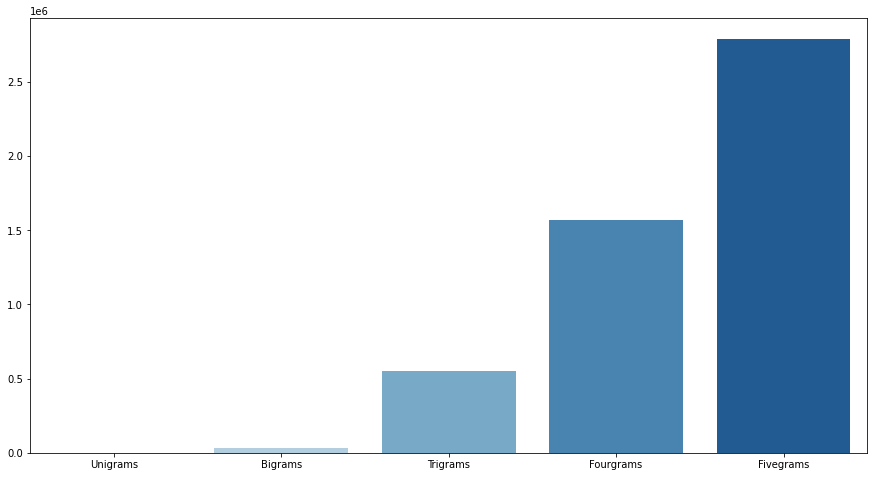

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# compute the number of all possible ngrams within our corpus 
ngram_sizes = [model.shape[0] * model.shape[1] for key, model in models.items()]

# create a dataframe that stores the number of all possible ngrams within our corpus
ngrams_sizes_df = pd.DataFrame(ngram_sizes, columns=['size'], index=['Unigrams', 'Bigrams', 'Trigrams', 'Fourgrams', 'Fivegrams']).transpose()

# print the dataframe
print(ngrams_sizes_df)

# plot the number of all possible ngrams within our corpus using a barplot 
sns.barplot(data=ngrams_sizes_df, palette='Blues')
plt.show()



---



## **Use your own model to suggest an upcoming word given your sentence**

This section of the notebooks allows to get suggestions for an upcoming word given a sentence as input, or for auto-completing the last word of the sentence, or for generating sentences using the trained language models.

Suggestions come from the ngram language models, built in the previous section.
For each ngram language models, we pick the most likely suggestion.



In [ ]:
def get_suggestions(sentence, prob_matrix, vocabulary, n=N_ORDER, preprocess=True, autocomplete=False):
  """
  Get suggestions from a ngram language model.

  Input:
    - sentence: input sentence
    - prob_matrix: k-smoothed probability matrix
    - vocabulary: vocabulary of the language model
    - n: order n of the language model
    - preprocess: flag for preprocessing input sentence
    - autocomplete: flag for autocomplete 
  Output:
    - word: suggested word by the language model
  """
  # check if preprocess is needed
  if preprocess:
    sentence = preprocess_sentence(sentence, n)

    # adjust sentence for next word suggestion
    if not autocomplete:
      last_word = sentence[-1]
      sentence = handling_oov(sentence[:-1], vocabulary)
      sentence.append(last_word)

  # extract pairs word-probability of ngrams dict for the prefix 
  if not autocomplete or n == 1:
    # get the prefix of the ngram of the given sentence
    prefix = tuple(sentence[-n:-1])

    # suggest most likely next word
    suggestions = {}
    for word in vocabulary:
      if word not in ['<UNK>', '<s>']:
        try:
          suggestions[word] = math.exp(prob_matrix[word][prefix]) 
        except KeyError:
          pass
  else:
    # get the prefix of the ngram of the given sentence
    prefix = tuple(sentence[-n-1:-2])

    # autocomplete last word
    suggestions = {}
    for word in vocabulary:
      if word.startswith(sentence[-2]) and word not in ['<UNK>', '<s>']:
        try:
          suggestions[word] =  math.exp(prob_matrix[word][prefix]) 
        except KeyError:
          pass

  # return most likely suggestion
  return [key for key in list(suggestions.keys()) if suggestions[key] == max(suggestions.values())][0] if suggestions else {}



###**Suggest the upcoming word**

In [ ]:
# input a sentence
example = input(prompt="Type a sentence: ")

# print the input sentence
print(f"sentence: {example}")

# get suggestions for each ngram language model
suggestions = {key: get_suggestions(example, prob_matrix, vocabularies[key], key, autocomplete=False) for key, prob_matrix in models.items()}

# print suggestions
pprint(suggestions)

Type a sentence: president of the united
sentence: president of the united
{1: 'the', 2: 'states', 3: 'states', 4: 'states', 5: 'states'}


### **Auto-complete the last word**

In [ ]:
# input a sentence
example = input(prompt="Type a sentence: ")

# print the input sentence
print(f"sentence: {example}")

# get suggestions for each ngram language model
suggestions = {key: get_suggestions(example, prob_matrix, vocabularies[key], key, autocomplete=True) for key, prob_matrix in models.items()}

# print suggestions
pprint(suggestions)

Type a sentence: the pres
sentence: the pres
{1: 'the', 2: 'president', 3: 'president', 4: 'president', 5: 'president'}


### **Generating sentences from the ngram language model**

In [ ]:
from nltk import word_tokenize
def generate_sentence(prob_matrix, vocabulary, n, end_token="<e>", preprocess=True, autocomplete=False):
  """
  Generate the most likely sentence for a given ngram language model.
  
  Input:
    - prob_matrix: k-smoothed probability matrix
    - vocabulary: vocabulary of the language model
    - n: order n of the ngram language model
    - end_token: end-of-sentence symbol
    - preprocess: flag for preprocessing
    - autocomplete: flag for autocomplete
  Output:
    - sentence: generated sentence
  """
  
  # assuming that "the" is the most likely starting word
  sentence = "the"
  

  # repeat until sentence is not large enough
  while len(word_tokenize(sentence)) < 20:

    # get suggestion for the upcoming word
    next_word = get_suggestions(sentence, prob_matrix, vocabulary, n, preprocess, autocomplete)

    # break if there is no suggestions or the upcoming word is the end-of-sentence-symbol
    if not next_word or next_word == end_token or next_word == word_tokenize(sentence)[-1]:
      break 

    # append suggested word to the sentence
    sentence = sentence + " " + next_word
  
  # return the generated sentence
  return sentence

# collect the generated sentences for the trained language models
generated_sentences = {idx: generate_sentence(models[idx], vocabularies[idx], idx) for idx in range(1, 6)}

# print the generated sentences
pprint(generated_sentences)




{1: 'the',
 2: 'the state .',
 3: 'the new administration in the state .',
 4: 'the new year the',
 5: 'the new year the'}




---

